<a href="https://colab.research.google.com/github/Mazgaliev/VBS_Analysis/blob/master/Analysis_Of_OpenData_Macedonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from datetime import date
from bs4 import BeautifulSoup
import warnings
import requests
from tqdm import tqdm_notebook as tqdm
import json
from datetime import datetime
import matplotlib.pyplot as plt


requests.packages.urllib3.disable_warnings()
warnings.filterwarnings("ignore")

#<font size=6 color='Orange'>*Api data gathering and parsing*</font>

##*Going through all the organizations and gathering the raw data and saving it*

In [4]:
#This function retrieves a dictionary of all the organizations based on their mapped names.
#This function is necessary because the data retrieved for the sets contains referenecs to the organizations and not the full object organization or title.
def getOrgNames(org):

  name=org['name']
  stat_code=500
  url= "https://data.gov.mk/api/3/action/organization_show"
  data={'id':name}
  while stat_code!=200:
    resp = requests.post(url,json=data)
    stat_code=resp.status_code
  org_data=json.loads(resp.text)['result']
  
  title=org_data['title']

  return title

In [5]:
#Getting all the organizations 

organizations= json.loads(requests.post("https://data.gov.mk/api/3/action/organization_list").text)['result']

In [6]:
#Gathering the data for dictionary.
orgs={}

for org in organizations:
  orgs[str(org['name'])]=getOrgNames(org)


In [7]:
#Get all the datasets from the API
json_data=json.loads(requests.get("https://data.gov.mk/api/3/action/package_list").text)

#Get the datasets as lists
datasets=json_data['result']

In [ ]:
datasets

In [9]:
#Get Metadata for each set
url="https://data.gov.mk/api/3/action/package_show"
def get_data(link):
  status=500
  parameters= {'id':link}
  while status !=200:
    resp = requests.post(url,json=parameters)
    status=resp.status_code
  data=resp.text
  # print("done with"+link)
  return data


In [10]:
from multiprocessing import Process,Queue
import multiprocessing

#Going through each dataset and getting metadata.
pool = multiprocessing.Pool(12)
all_data=pool.map(get_data, datasets)

In [11]:
#Raw metadata unmodified
metadata=pd.DataFrame(all_data,columns=["TEXTUAL_METADATA"])

In [12]:
metadata.to_csv("TEXTUAL_METADATA_OF_SETS",index=False)

##*Processing the data*

In [14]:
#Gathering the necessary as a dataframe structured data from the api data returned.
# ["set_id","Одржувач","е-маил","Наслов","Дата креирање","Дата модифициран","лиценца","Име на организација","Формат","Големина во KB","Отвореност"]
def getStructuredData(ds):
  final_data=[]

  data=json.loads(ds)['result']

  openness= None
  qa=None
  maintainer=None
  maintainer_email=None
  organization=None
  calculated_openness=None

  set_id=data['id']

  try:
    maintainer=data['maintainer']
    if maintainer =="":
      maintainer="NO_MAINTAINER"
  except:
    maintainer="NO_MAINTAINER"
    pass

  try:
    maintainer_email=data['maintainer_email']
  except:
    maintainer_email="NO_MAINTAINER_EMAIL"
    pass

  title=data['title']
  date_created = datetime.strptime(data['metadata_created'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')

  date_modified=datetime.strptime(data['metadata_modified'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
 
  try:
    license=data['license_id']  
    if license=="":
      license= "notspecified"
  except:
    license="notspecified"
    

  try:
    organization=data['organization']
    org_name=orgs[organization['name']]
  except:
    org_name="NO ORGANIZATION"

  if license == "notspecified":
      openness="0"

  try:
    qa=data['qa']
    openness=qa['openness_score']
  except:
    qa=None
    openness="0"
  
  resources=data['resources']

  for r in resources:
    resource_format=r['format']
    resource_size=r['size']
    
    doc_updated="NOT_SPECIFIED"
    doc_created="NOT_SPECIFIED"

    try:
      archiv=r['archiver']
      doc_updated=datetime.strptime(archiv['updated'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
    except:
      doc_updated="NOT_SPECIFIED"
    try:
      doc_created=datetime.strptime(r['created'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
    except:
      doc_created="NOT_SPECIFIED"

    if resource_format=="":
      resource_format="NOT_SPECIFIED"
    elif resource_format==".csv":
      resource_format="CSV"
    elif resource_format=="XLS" or resource_format=="xlxs" or resource_format==".xlxs" or resource_format==".xlsx":
      resource_format="XLSX" 
    elif resource_format==".pdf":
      resource_format="PDF"
    elif resource_format==".xml":
      resource_format="XML"

    one_star=["DOC","DOCX","PDF"]  
    two_star=["XLSX", "XLS", "MDB", "EXCEL"]
    three_star=[
        "CSV","comma separated values","tsv","tab separated values","wms","web mapping service","geojson","wfs","web feature service","kml","kmz","JSON","XML","shp","rss","gpx"]
    four_star=["sparql","rdf","relational document format","json ld","asc"]

    if resource_format in one_star:
      calculated_openness=1
    elif resource_format in two_star:
      calculated_openness=2
    elif resource_format in three_star:
      calculated_openness=3
    elif resource_format in four_star:
      calculated_openness=4
    else:
      calculated_openness=openness
      calculated_openness=int(calculated_openness)
    if resource_size==None:
      resource_size=0
    final_data.append([set_id,maintainer,maintainer_email,title,date_created,date_modified,license,org_name,resource_format,resource_size/(1024),doc_created,doc_updated,calculated_openness,openness])


  return pd.DataFrame(final_data,columns=["set_id","Одржувач","е-маил","Наслов","Дата креирање","Дата модифициран","лиценца","Име на организација","Формат","Големина во KB","Док Креиран","Док модификуван",'Проценета_отвореност',"Отвореност"])

In [15]:
#Gather the saved data
import pandas as pd
metadata=pd.read_csv("TEXTUAL_METADATA_OF_SETS")

In [16]:
import json

In [18]:
#Saving the (PROCESSED) metadata in a single dataframe
final_frame=pd.DataFrame(columns=["set_id","Одржувач","е-маил","Наслов","Дата креирање","Дата модифициран","лиценца","Име на организација","Формат","Големина во KB","Док Креиран","Док модификуван",'Проценета_отвореност',"Отвореност"])
for ds in metadata.iloc():
  df=getStructuredData(ds[0])
  
  final_frame=pd.concat([final_frame,df])

In [19]:
#Saving the metadata to csv format
final_frame.to_csv("Structured_data_from_set",index=False)

In [21]:
#Read the dataframe
final_frame=pd.read_csv("Structured_data_from_set")

In [ ]:
final_frame.head()

#<font size=6 color='Orange'>*Visualizations*</font>

##<font color='Green'> *The openness of open data in Macedonia visualization*. </font>

<Axes: >

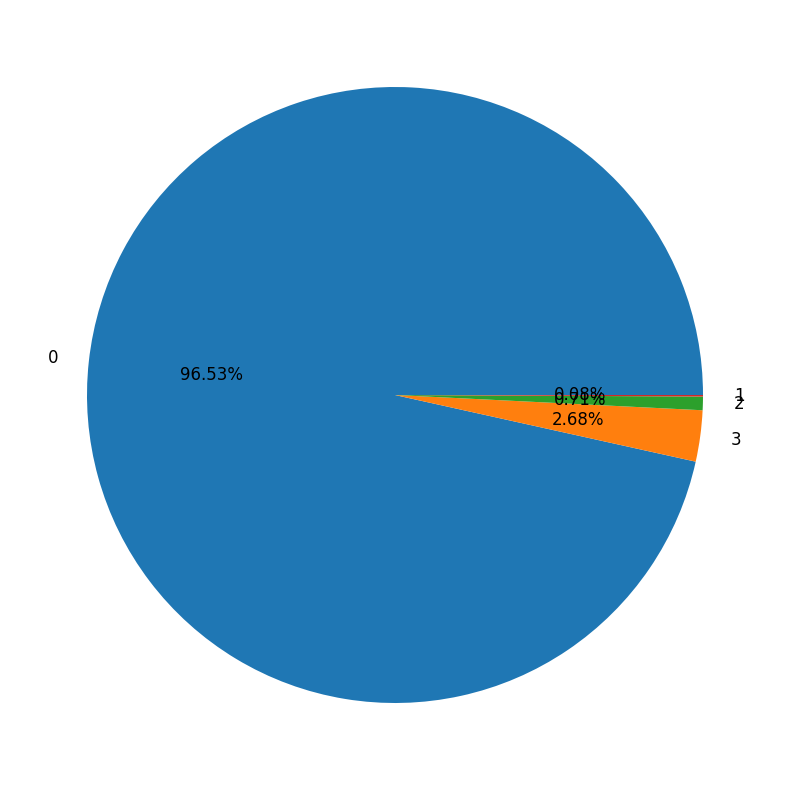

In [23]:
final_frame['Отвореност'].value_counts().plot.pie(
    figsize=(13,10),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,
           )

<Axes: >

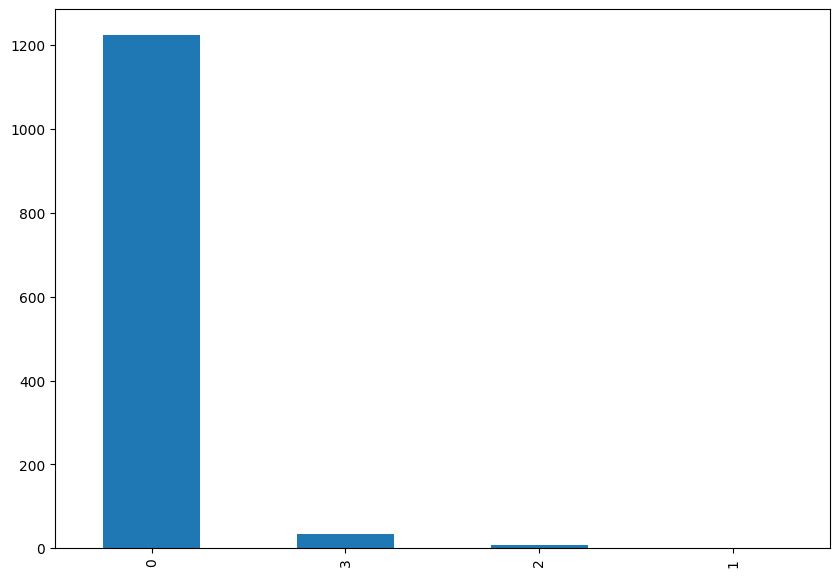

In [24]:
final_frame['Отвореност'].value_counts().plot.bar(figsize=(10,7))

<font color='White'>From the above figures we can see that Macedonia is dominated by open data rated with 0 stars (a **96.5%** without any open license). And the maximum openness is 3 star, which means that the data is stored in a computer readable format such as CSV.</font>

##<font color='Green'>*Visualization of the the organizations activity* </font>


<Axes: xlabel='Име на организација'>

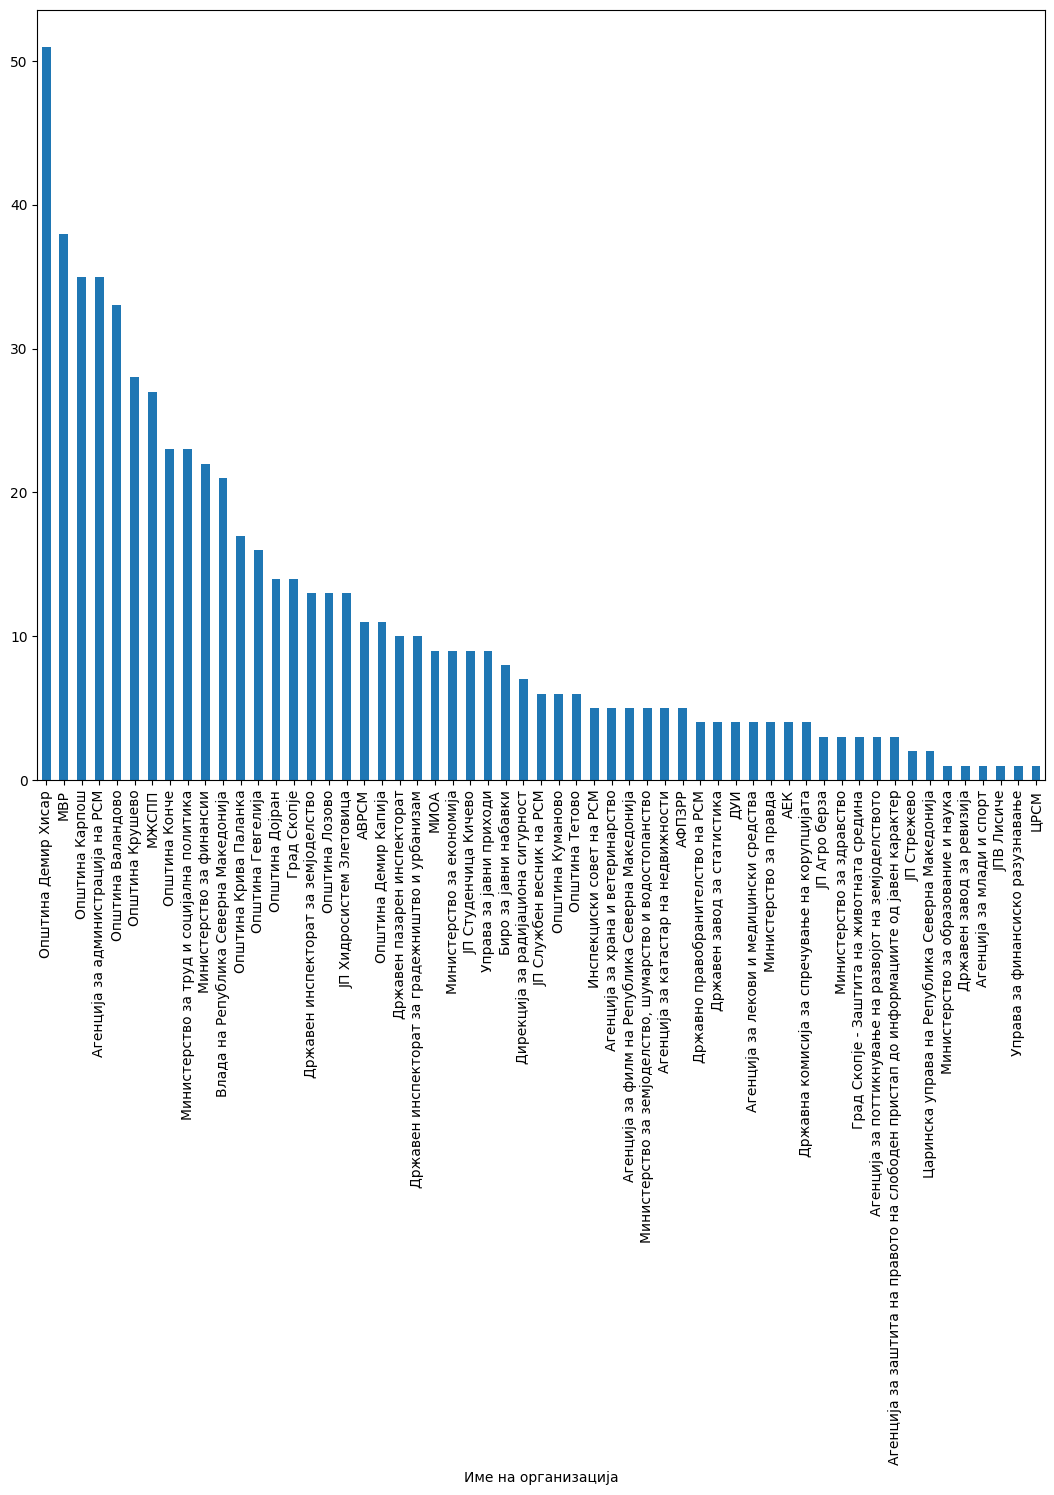

In [25]:
plt.xticks(rotation=90)
final_frame[['set_id','Име на организација']].drop_duplicates().value_counts('Име на организација').plot.bar(figsize=(13,10))

<font color='Green'>*Ths visualization shows the amount of datasets that each organization has published ranked from most to least, and we can see that municipality "Општина Демир хисар" stands first with 51 sets and "ЦРСМ" last with 1 dataset*.</font>

---




##<font color='Green'> Visualization of max openness of open data in each organization.</font>

<Axes: xlabel='Име на организација'>

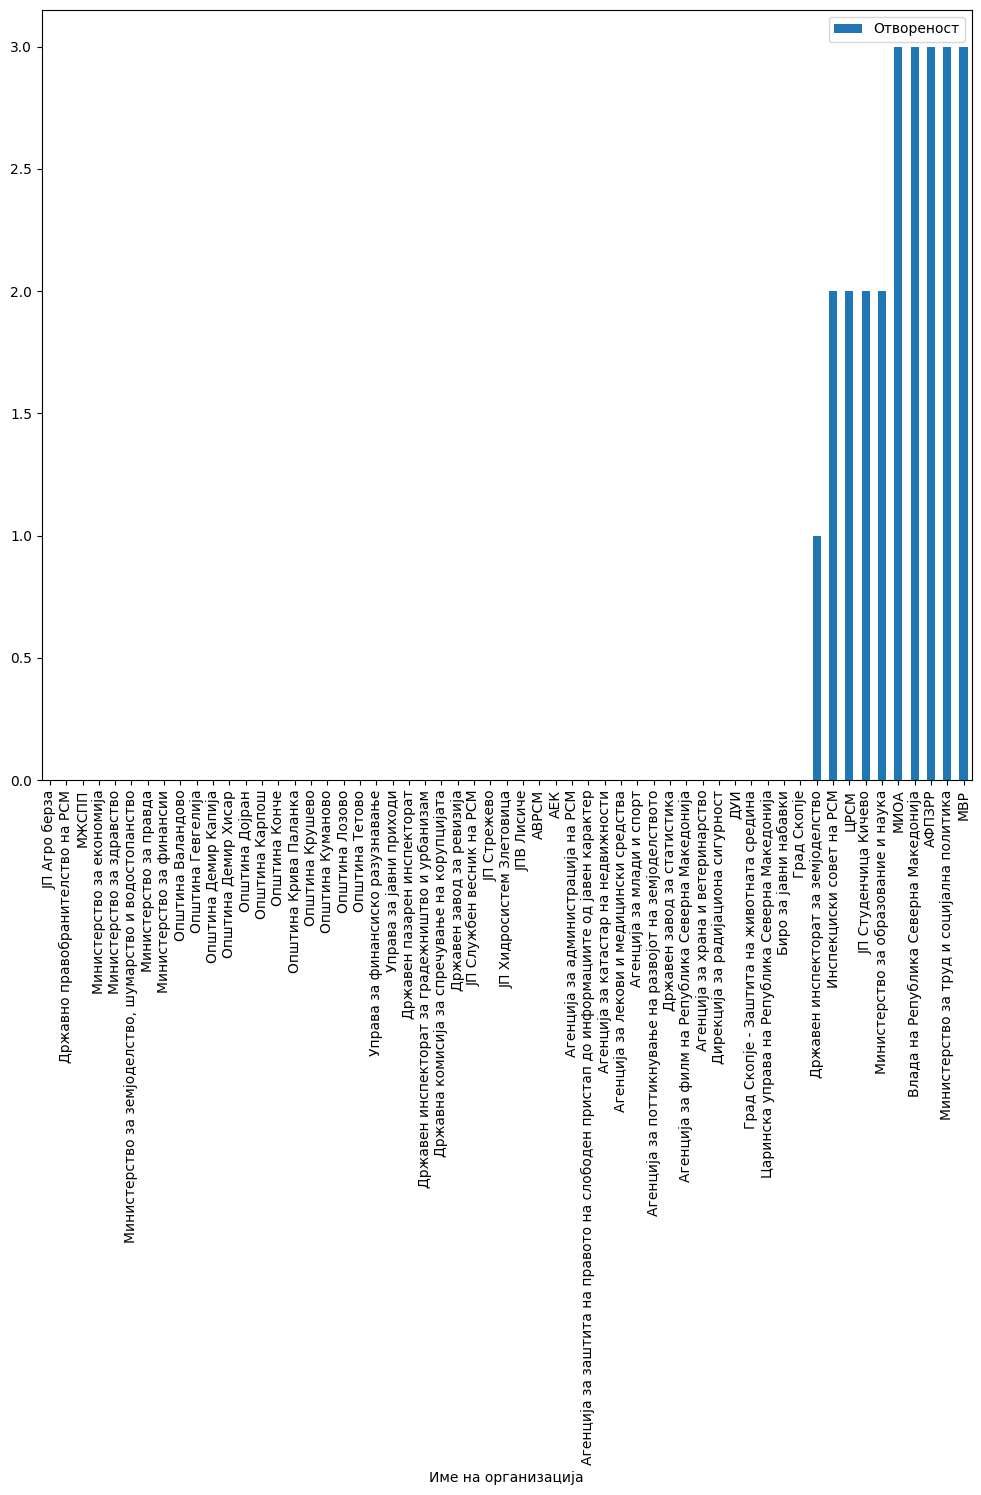

In [26]:
final_frame[['Отвореност','Име на организација']].groupby(["Име на организација"]).max().reset_index().sort_values(by='Отвореност').plot.bar(x="Име на организација",figsize=(12,10))

<font size = 4 color ='White'>This visualization shows each organizations' datasets openness ranking them from low to high, and we can see that organizations such as 'МВР' have 3 star open data which is the maximum in Macedonia and 'МОН' has 2 star data which means that the data has some readable structure.</font>


---


<font color='White' size =4>Still 3 star data is good because anyone with a computer can easily access and process the 3 star data and the 2 star data.


##<font color='Green' size=5>Visualization of the number of documents each organization has put out.</font>


<Axes: >

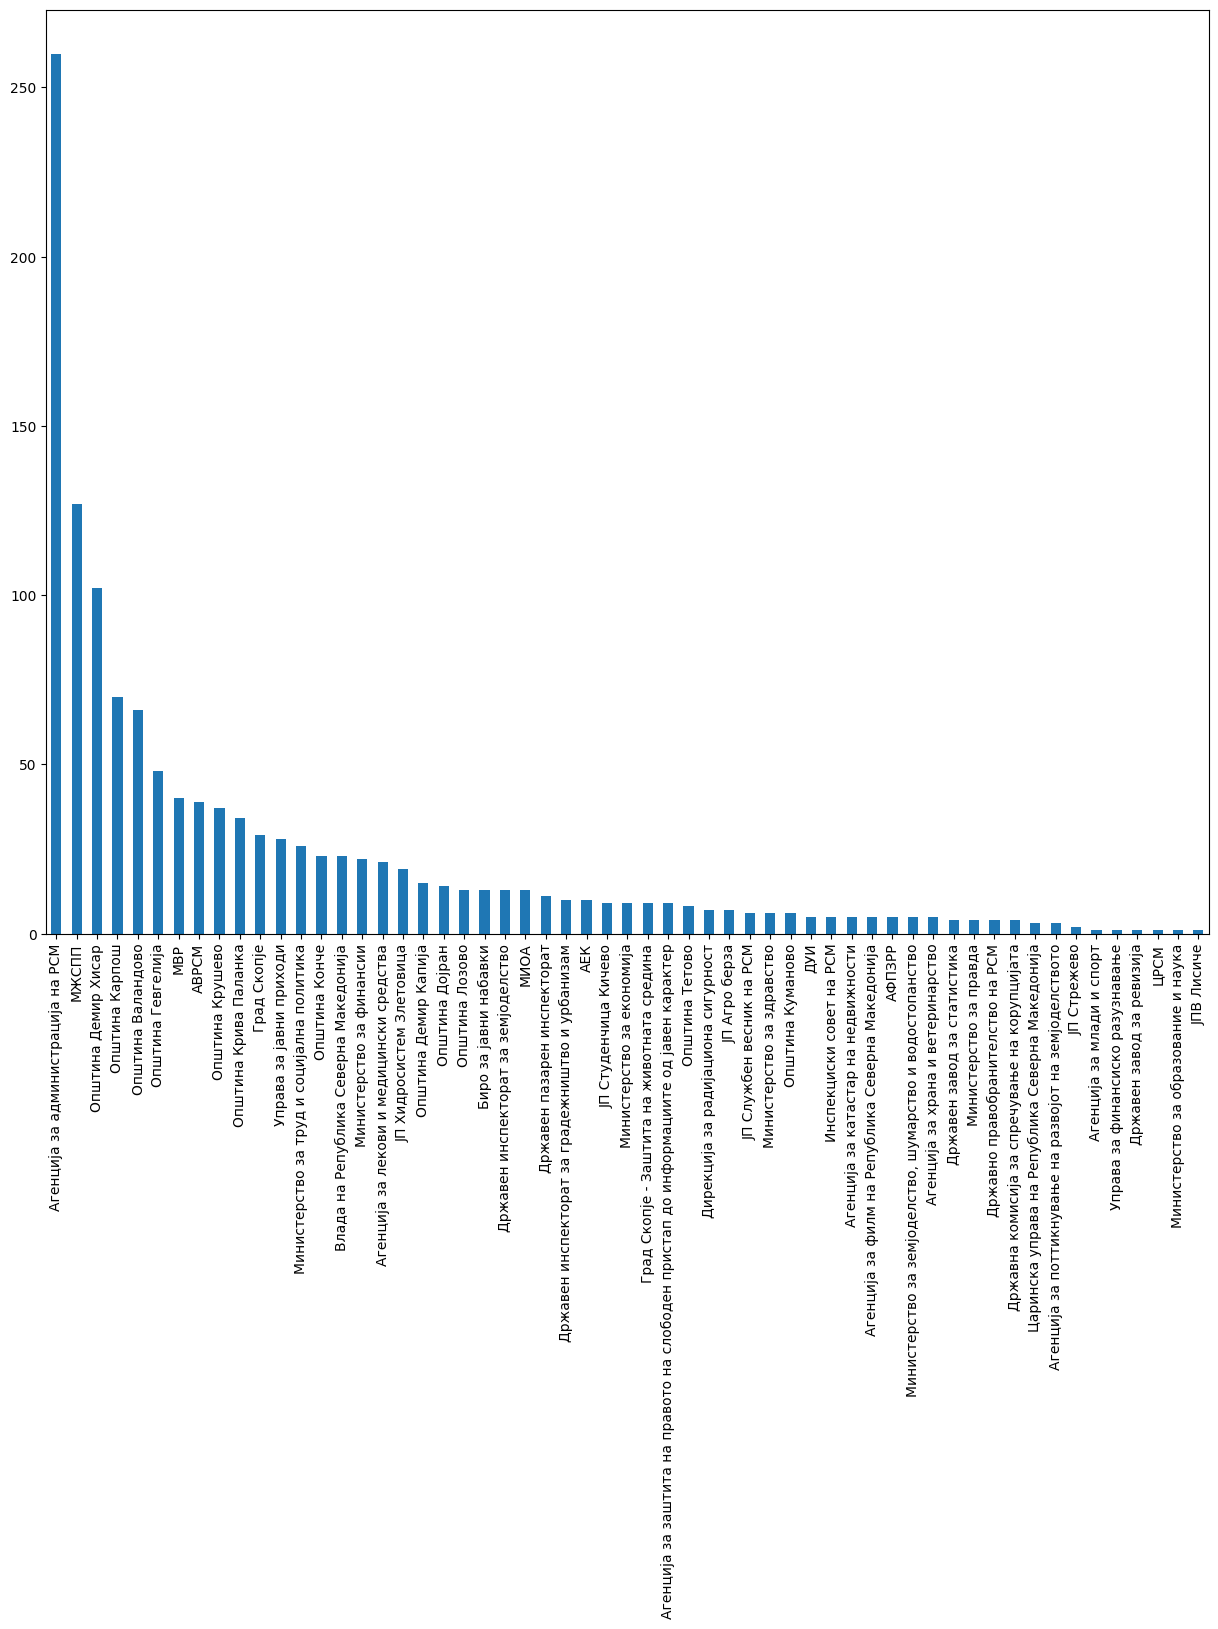

In [27]:
final_frame['Име на организација'].value_counts().plot.bar(figsize=(15,12))


<font color='White' size = 3>This shows theat the agency of administration in Macedonia has the most documents uploaded. As we can see at the stop stands Agency of administration of Macedonia.</font>

<Axes: xlabel='Одржувач'>

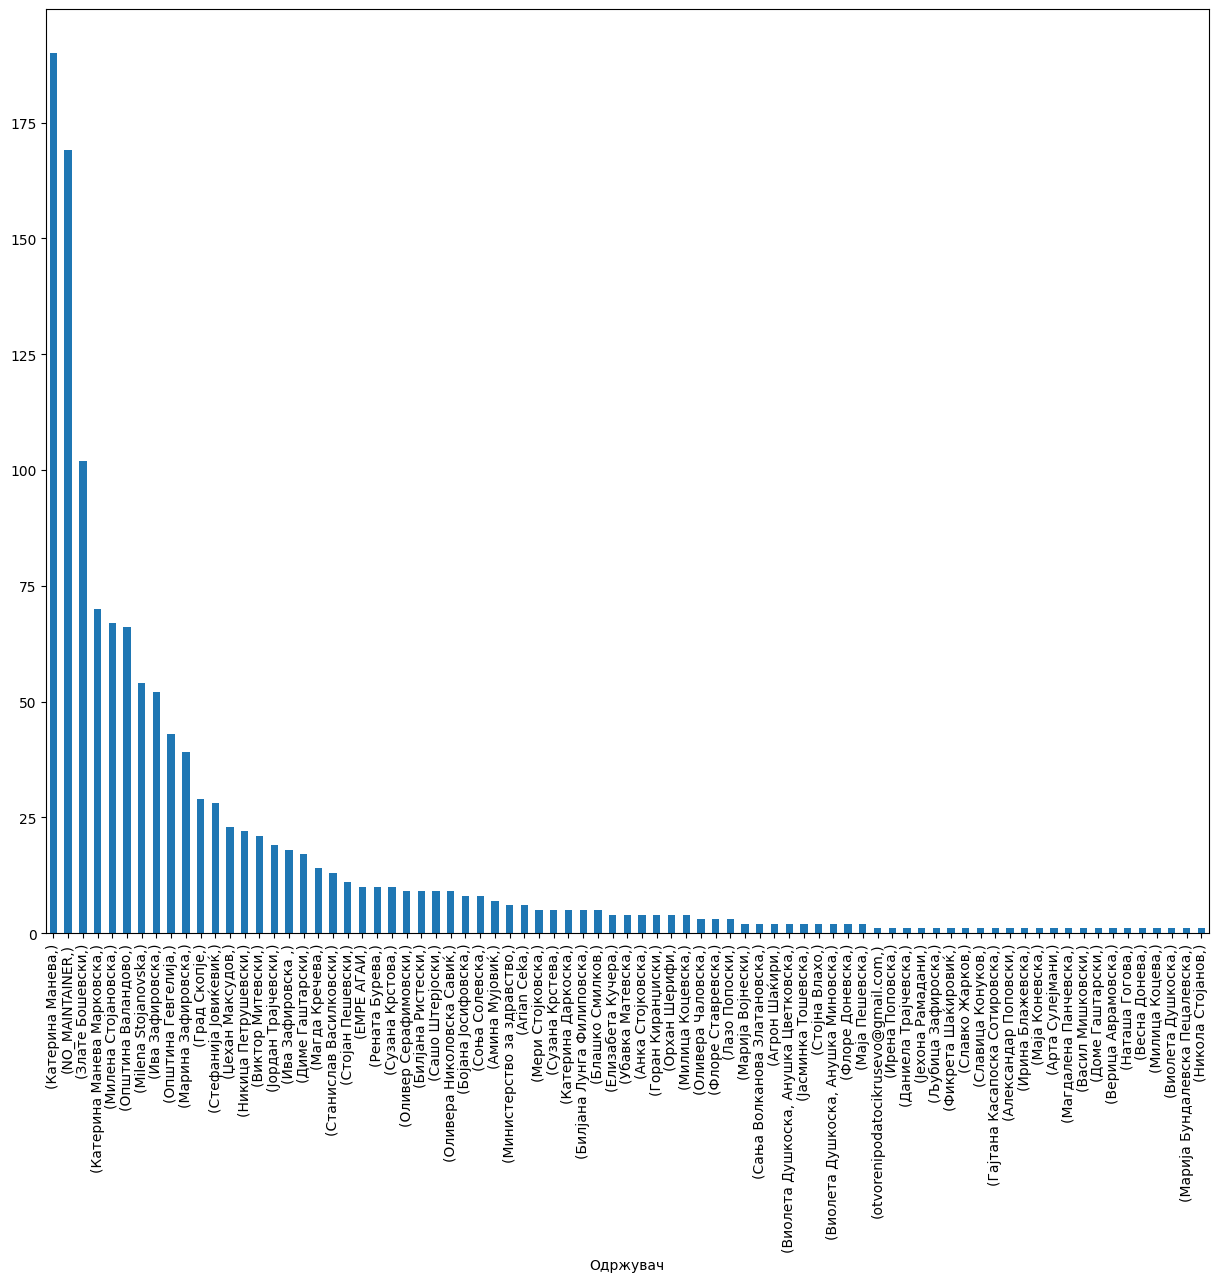

In [28]:
final_frame.value_counts(["Одржувач"]).plot.bar(figsize=(15,12))
#Визуелизација на кои одржувачи се поврзани со најмногу документи за одржување.

<font size=4 color='Green'>This visualization shows the maintainers of datasets and the amount of documents each maintainers maintain.</font>

<font> The dataset maintainers can be contacted in case of some errors in the datasets that need to be fixed, or to contact them for more information regarding the data in the datasets they maintain.</font>

<font color='Red' size=2>In the case where there is no specified maintainer of the dataset the maintainers would be the Organization which has made that specific set.</font>

##<font color='Green' size=5>Visual representation of the amount of data each  that each organization has shared.</font>

<Axes: xlabel='Име на организација'>

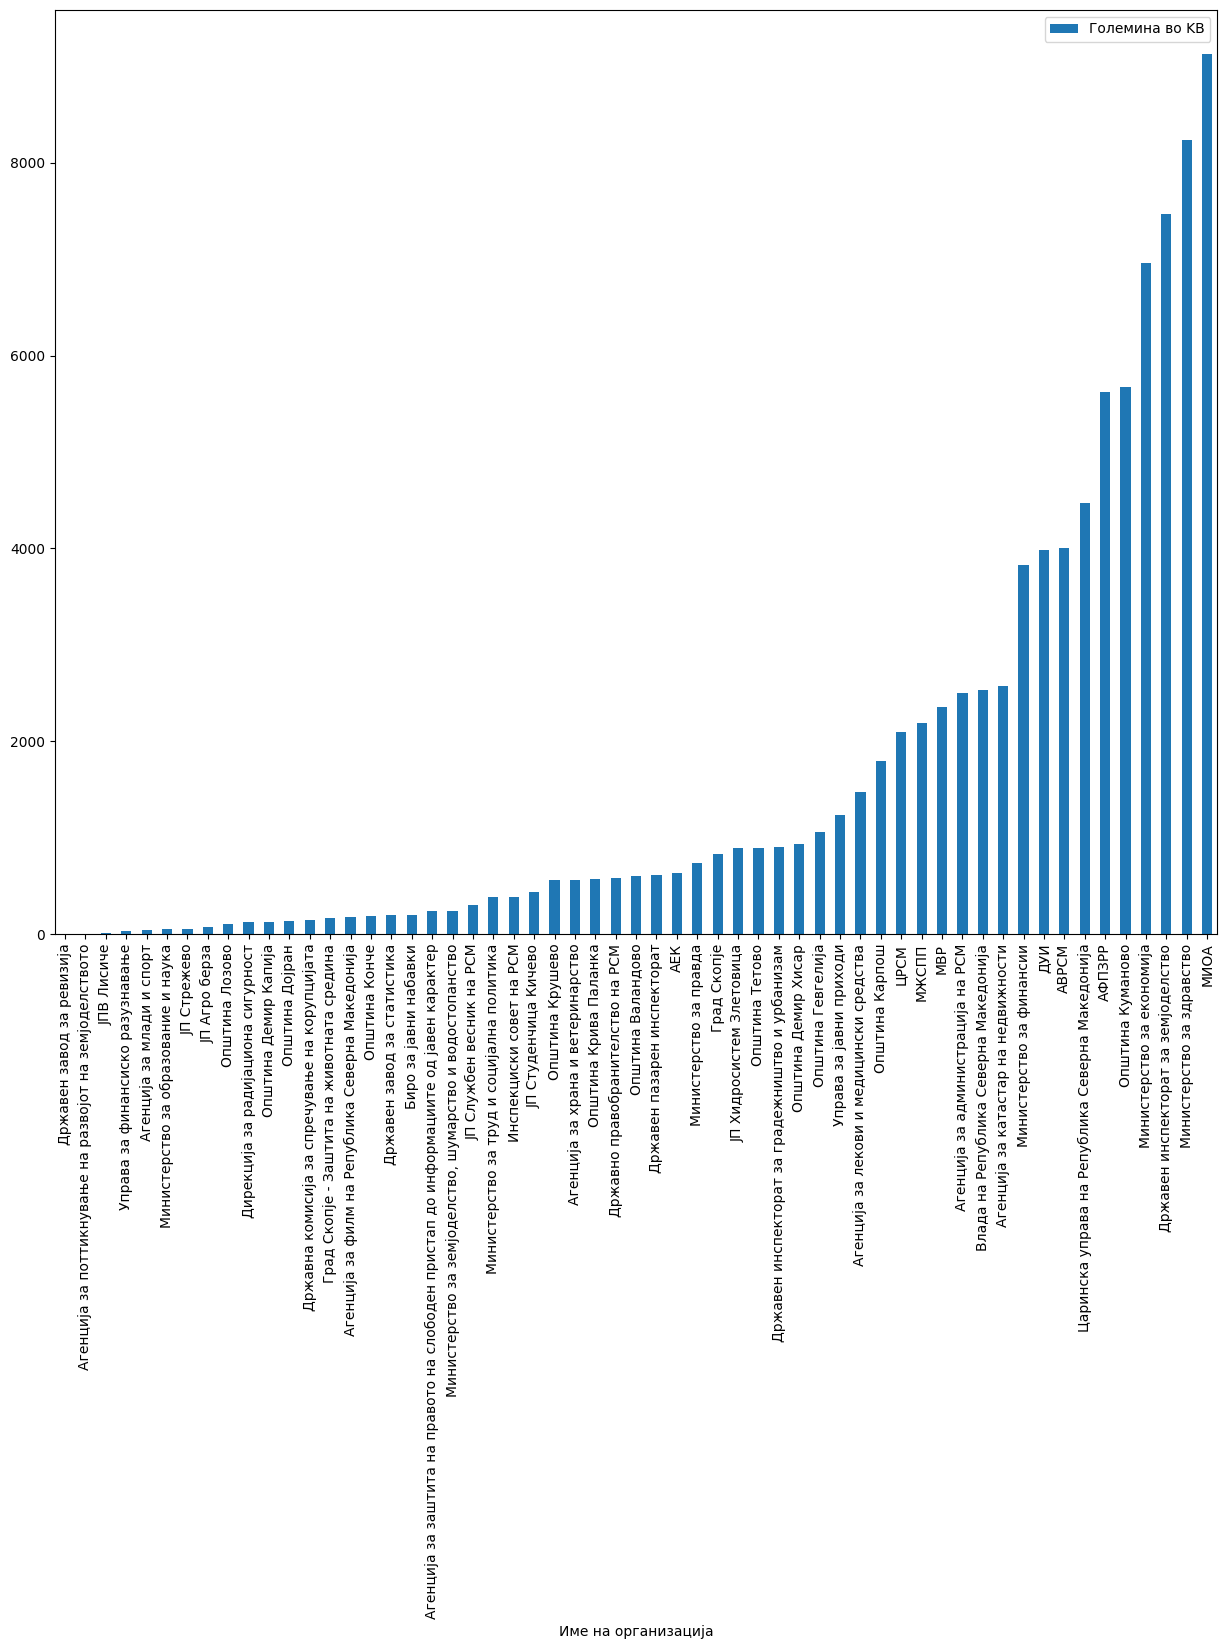

In [29]:
new_df=final_frame[["Име на организација","Големина во KB"]].groupby("Име на организација").sum().reset_index()
new_df.columns=["Име на организација","Големина во KB"]
new_df.sort_values(by="Големина во KB").plot.bar(x="Име на организација",figsize=(15,12))
#Визуелизација на тоа колку севкупно количински во МB има поставено секоја организација од сите документи нејни м-ва.


<font>In this visualization we can see the volume of data each organization has,
ranking at first we have "МИОА" at around 9 Megbytes of data and ranking second  the ministry of health at 8 Megabytes.
</font>

##<font color='Green' size=5>Time series visualization on the amount of Data sets created and edited between the start and present day of storing open data.</font>

In [30]:
dates=final_frame['Дата креирање'].str.split(" ").tolist()
data=[]
for d in dates:
  data.append(d[0])

In [31]:
final_frame['Дата креирање']=pd.DataFrame(data,columns=["Дата креирање"])


In [32]:
new_df=final_frame.value_counts(["set_id",'Дата креирање']).to_frame().reset_index()
new_df.columns=["ID","Дата креирање", "Број"]

In [33]:
new_df.drop(columns=['ID'],inplace=True)

<Axes: xlabel='Дата креирање'>

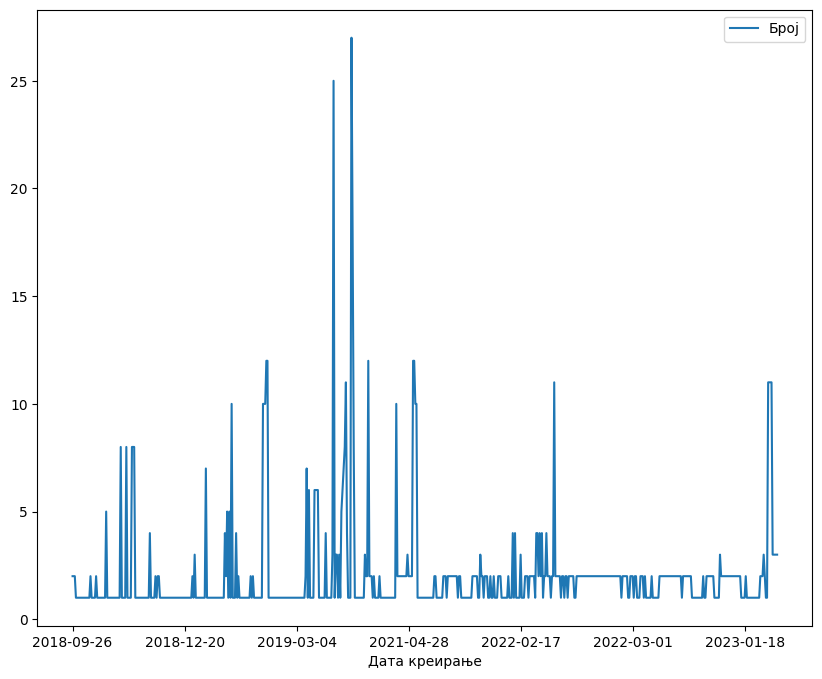

In [34]:
new_df.sort_values(by="Дата креирање").plot(x="Дата креирање",figsize=(10,8))
#Оваа визуелизација покажува колку податочни м-ва има креирано во рангот на датите помеѓу 2018-09-26 и 2023-02-01

<font color='Green'>This time series shows the amount of data that has been submitted as open data in Macedonia, ranging from 2018-09-26 to 2023-02-01</font>

<font size = 4 color='White'>
We can see that the peak of datasets created were in the dates between the third of March 2019 and the end of April 2021.

And also it can be noted that every year we have a rush of datasets that get created in a short period of time apart from the last 2 years, between May 2021 and present date the amount of datasets posted has declined.
</font>

In [35]:
dates=final_frame['Дата модифициран'].str.split(" ").tolist()
data=[]
for d in dates:
  data.append(d[0])

In [36]:
final_frame['Дата модифициран']=pd.DataFrame(data,columns=["Дата модифициран"])

In [37]:
new_df=final_frame.value_counts(["set_id",'Дата модифициран']).to_frame().reset_index()
new_df.columns=["ID","Дата модифициран", "Број"]
new_df.drop(columns=["ID"],inplace=True)

<Axes: xlabel='Дата модифициран'>

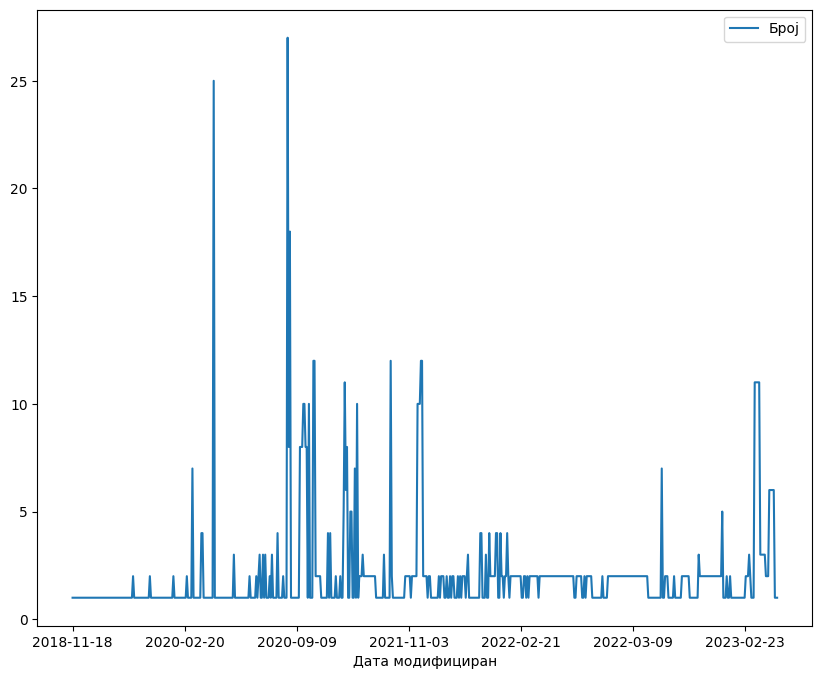

In [38]:
new_df.sort_values(by="Дата модифициран").plot(x="Дата модифициран",figsize=(10,8))
#Оваа визуелизација покажува колку податочни м-ва има модифицирано/променето и кога во рангот на датите помеѓу 2018-09-26 и 2023-02-01

<font color='White' size=4>This visualization shows the rate at which datasets get updated during the time between the beginning of storing open data and present day.

We can see that between 2019 and 2021 we have the most modifications and updated made to the datasets which is correlated with the data sets created during the same period, which means they get posted then modified due to some problems in the datasets errors missing values and so on.

And after this period the data we can see that there are some small peaks of data sets modified, some yearly monthly and so on.
</font>

<font color='White' size=4></font>

##<font color='Green' size=5>Time series visualization of the amount of documents created and edited between the start and present day of storing open data</font>

In [39]:
dates=final_frame['Док Креиран'].str.split(" ").tolist()
data=[]
for d in dates:
  data.append(d[0])

final_frame['Док Креиран']=pd.DataFrame(data,columns=["Док Креиран"])

new_df=final_frame.value_counts(['Док Креиран']).to_frame().reset_index()
new_df.columns=["Док Креиран", "Број"]

<Axes: xlabel='Док Креиран'>

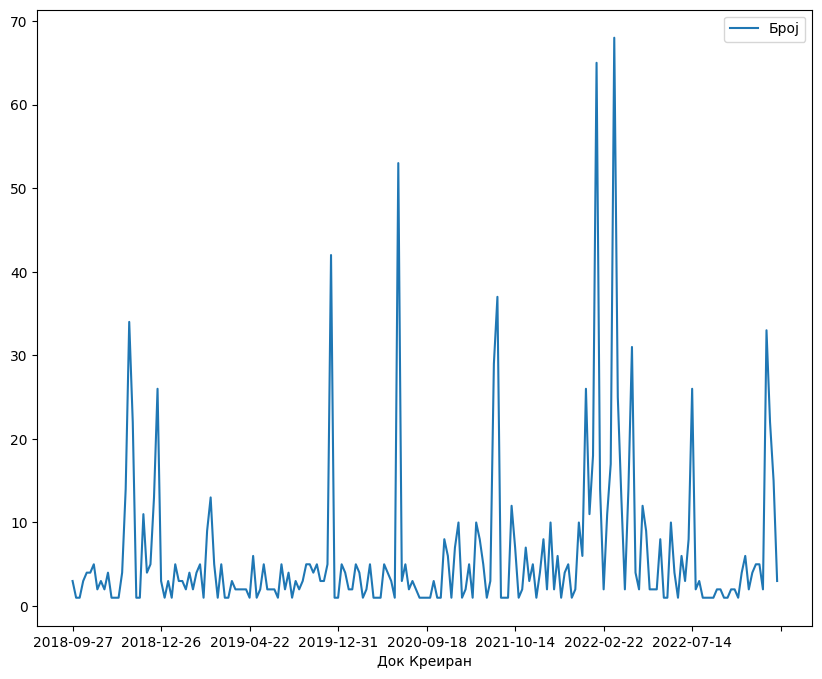

In [40]:
new_df.sort_values(by="Док Креиран").plot(x="Док Креиран",figsize=(10,8))

<font color='Green' size=5>This visualization shows the rate at which documents were created from the beginning of storing open data in Macedonia 2018 and 2023-02.</font>


---


<font color='White' size=4>It can be noted that the organizations that post documents are active all troughout the year, we can see from the graph that very rarely do some periods fall below 5 documents per month.</font>

In [41]:
new_df=final_frame.value_counts(['Док модификуван']).to_frame().reset_index()
new_df.columns=["Док модификуван", "Број"]

<Axes: xlabel='Док модификуван'>

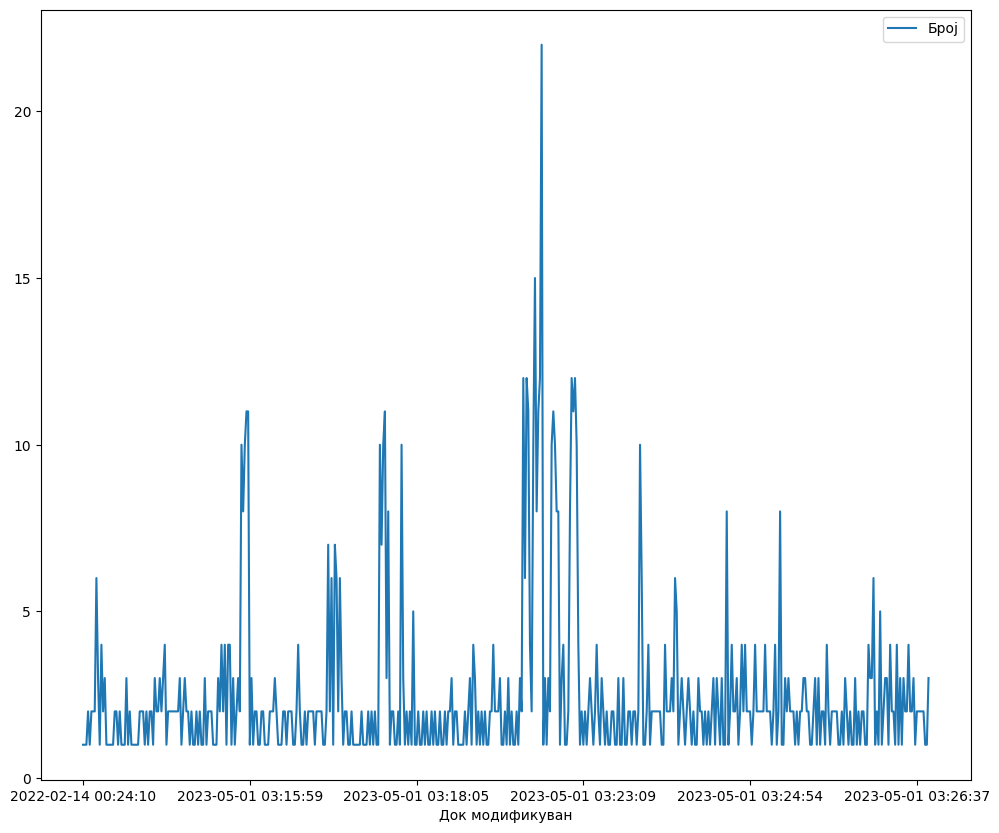

In [42]:
new_df.sort_values(by="Док модификуван").plot(x="Док модификуван",figsize=(12,10))
#Оваа визуелизација покажува колку податочни м-ва има креирано во рангот на датите помеѓу 2018-09-26 и 2023-02-01

<font color='White' size=4>As we can see from this visualization there is a small number of documents that were modified for the last time over a year ago, and the rest of the other documents were updated one month ago in the same day between 3:16:04 AM and 03:28:08 AM. </font>

<font color='Red' size=3>From this visualization we can't get much information out, more analysis needs to be done to see how frequently the documents get modified/updated.

All we can see now is that almost all of them get updated in the same time frame.</font>

##<font color='Green' size=5>Pie visualization of the distribution of the formats of all the documents</font>

<Axes: >

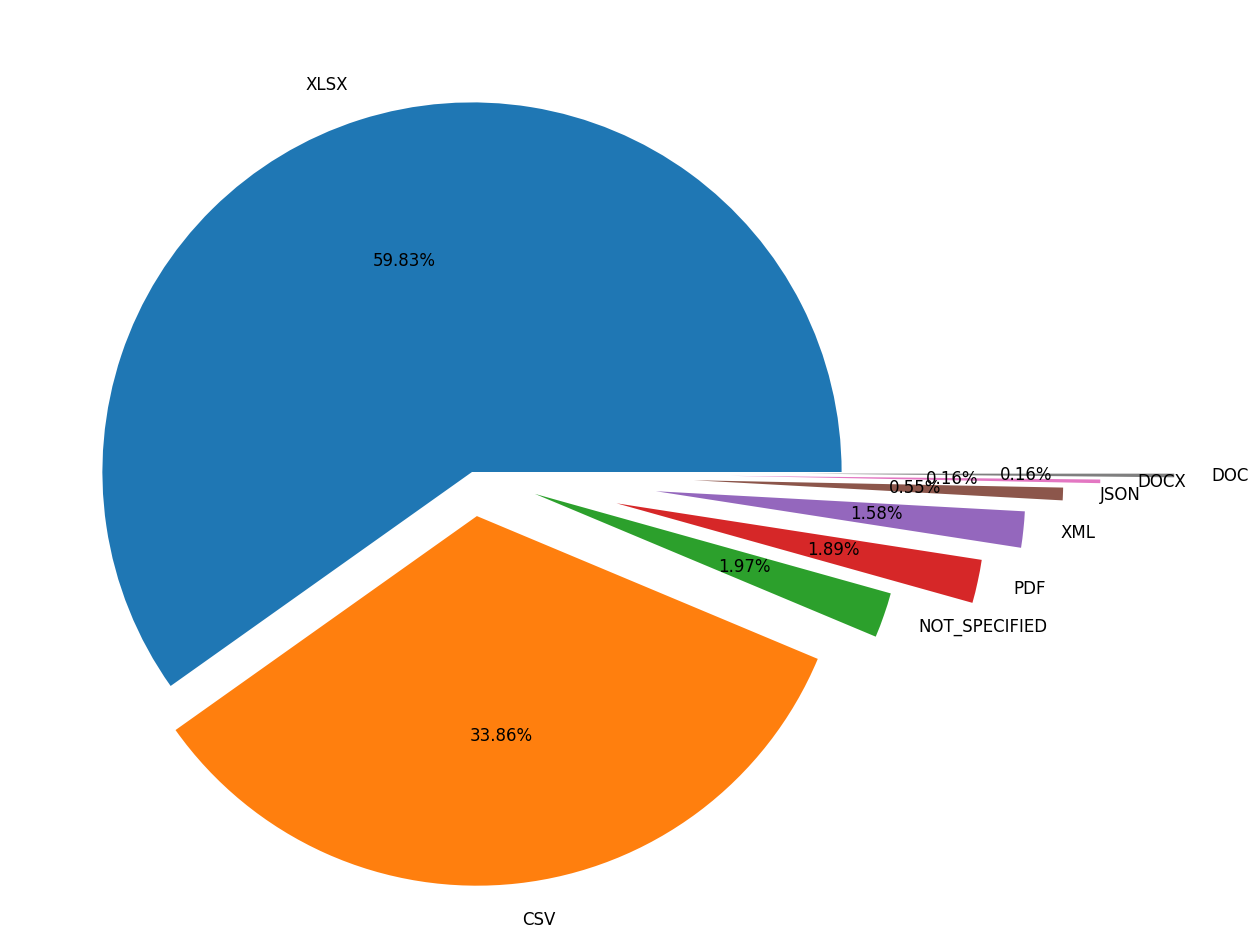

In [43]:
final_frame['Формат'].value_counts().plot.pie(
    figsize=(15,12),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,
           explode=(0,0.12,0.18,0.4,0.5,0.6,0.7,0.9))

#Оваа визуелизација покажува колку м-ва има процентуално во секој од форматите. 

<font color='Green' size=4> We can see from the above vizualization that in Macedonia the dominating document formats are XLXS **57%** and CSV **36%** which is good, because these formats can easily be processed by computers and be easy to do some statistical analysis on.</font>

<font color='Red' size=3>Note that even though the documents are dominated by these formats there are many mistakes in all of them which still makes up for the 0 star rating (unlicensed) most of them have.</font>

<font color='Red' size=3>Note that there is a section of NOT_SPECIFIED documents, which have some format in which they are stored but are not well documented from the maintainers.</font>

##<font size=5 color='Green'>Visualizations of the calculated data openness in Macedonia</font>


---
The way open the openness score is calculated is by checking the documents formats according to Tim Berners-Lee.

1.   1-Star is DOC,DOCX,PDF
2.   2-Star is EXCEL documents xls xlsx..
3.   3-Star CSV formats, comma seperated data
4.   4-Star sparql,rdf..

And for 5 star it can't be automated yet. Your data needs to Link to other data for more context.




<Axes: >

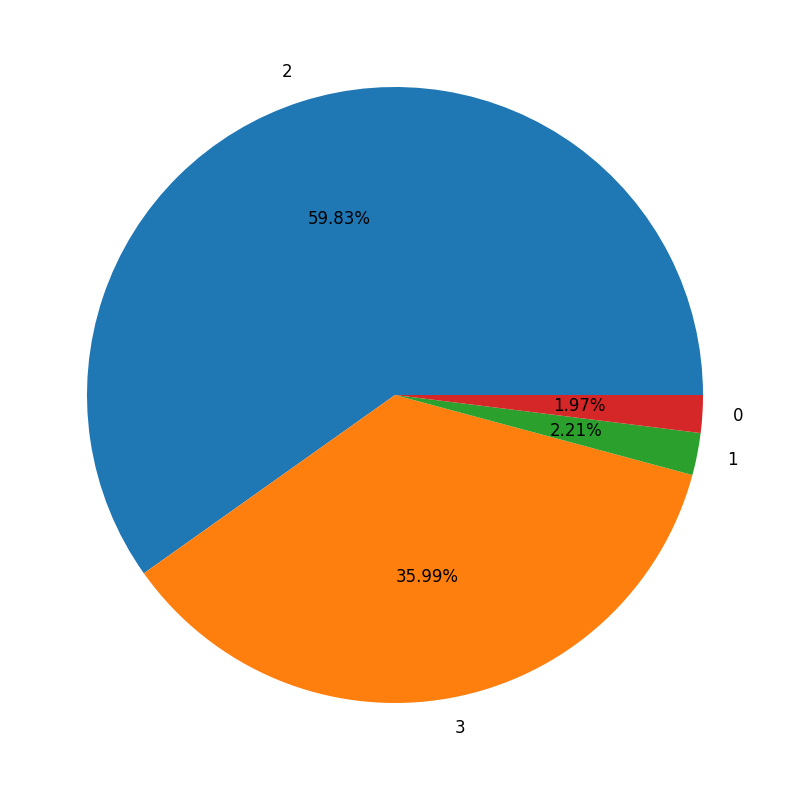

In [44]:
final_frame['Проценета_отвореност'].value_counts().plot.pie(
    figsize=(13,10),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,)

<font size=4 color='White'>From the pie chart we can see that over 50% of the documents in data gov Macedonia is in a 2-star data form, which means they are in EXCEL format, 38% are in a 3-star data format comma seperated data, CSV and 2% 1-star which is in a format such as PDF, DOC, DOCX and another 2% unrated or empty. Sadly there arent't any 4 and 5 star datasets.</font>


---

<font color='Red'>Apart from the errors in the documents which loses them the open license the state of open data is good based on the format of documents and there is still room for improvement.</font>

<Axes: xlabel='Име на организација'>

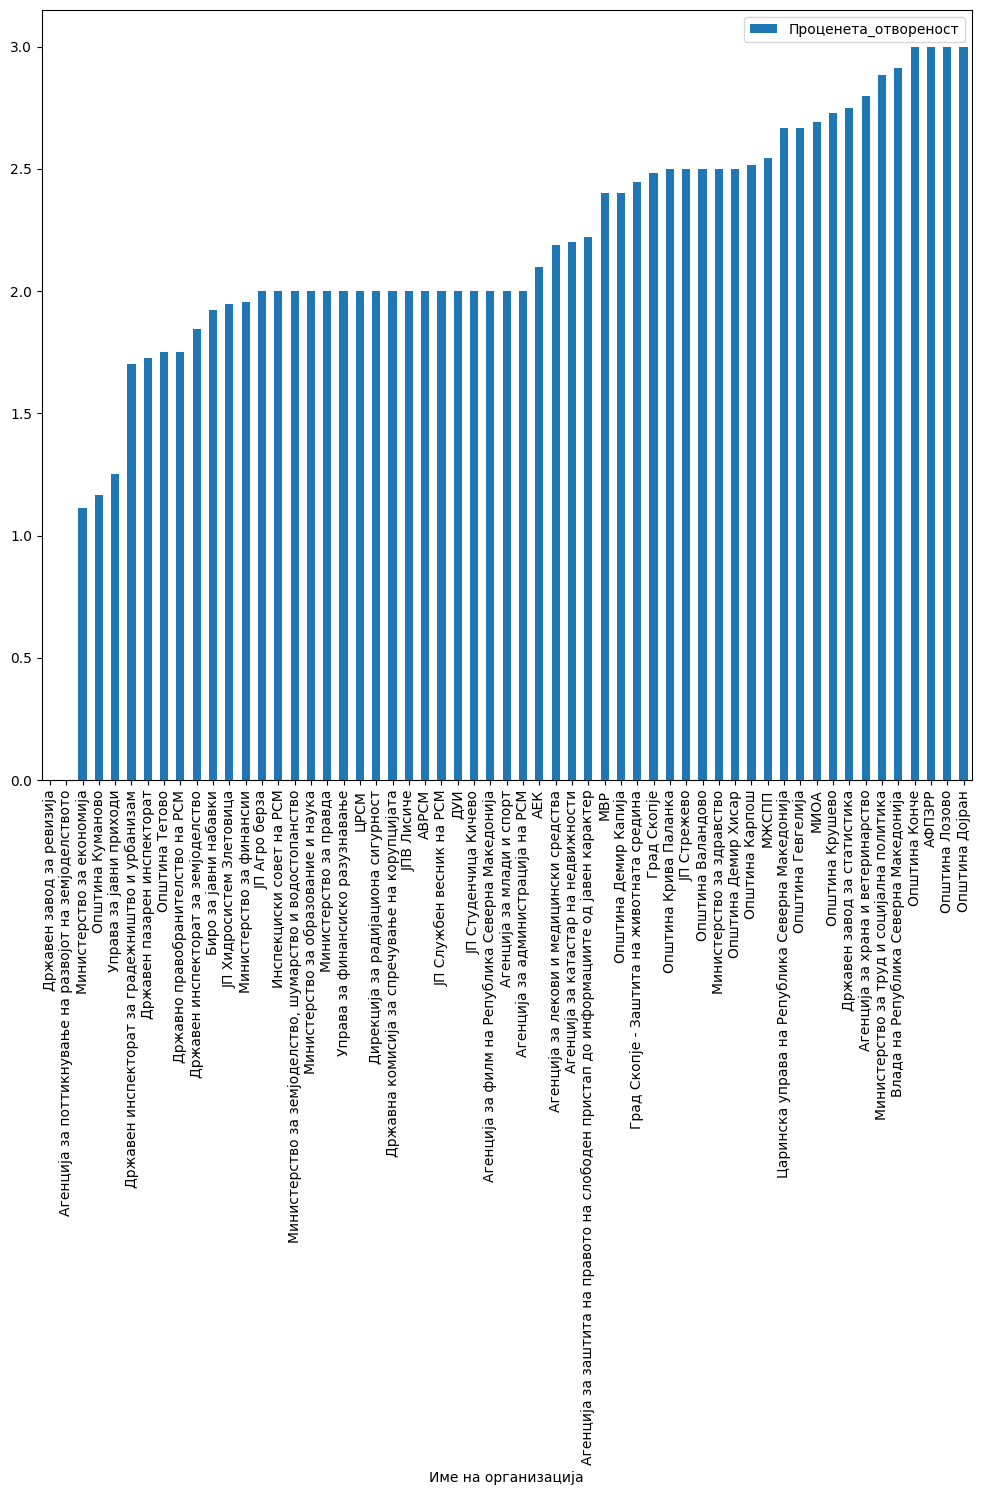

In [45]:
final_frame[['Проценета_отвореност','Име на организација']].groupby(["Име на организација"]).mean().reset_index().sort_values(by='Проценета_отвореност').plot.bar(x="Име на организација",figsize=(12,10))

<font size=4 color='White'>This visualilzation shows the ranking of each of the organizations' datasets average start rating, starting at the lowest LEFT** (Државен завод за ревизија)** and standing at the top 4 with average 3 star average rating АФПЗЗР, Дојран, Лозово and Конче.</font>


---
This visualization in a way shows that some organizations are transfering their documents from lesser formats to more machine readable formats and for that their average is in between the actual rating.



<Axes: >

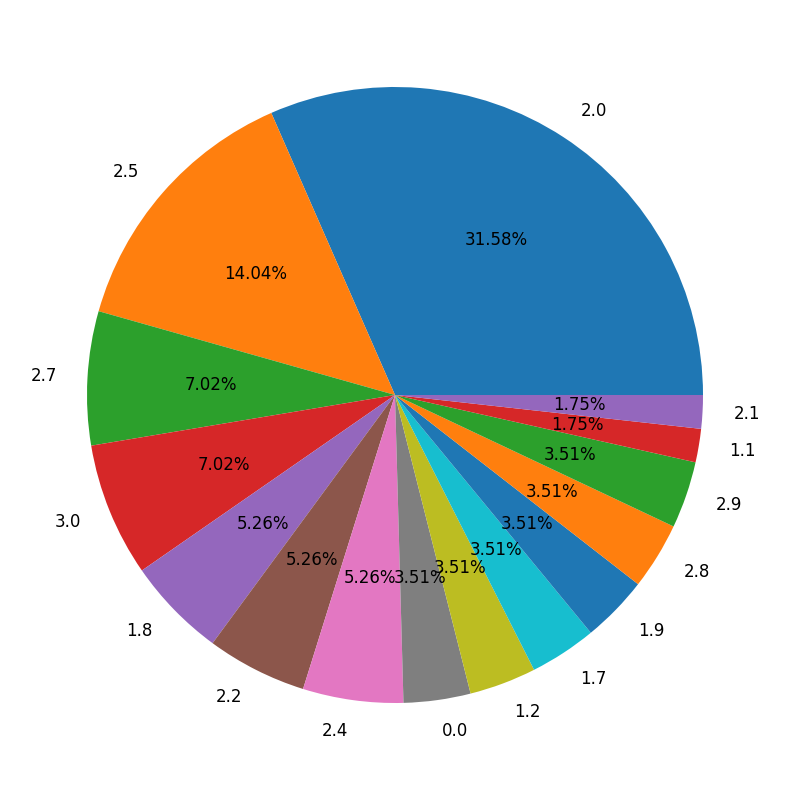

In [46]:
final_frame[['Проценета_отвореност','Име на организација']].groupby(["Име на организација"]).mean().reset_index().round(decimals=1).sort_values(by='Проценета_отвореност').value_counts("Проценета_отвореност").plot.pie(
    figsize=(13,10),
                y="Counts",
          autopct='%1.2f%%',
           ylabel='',
           fontsize=12,
)

<font size=4 color='White'>Here we have a visualization of the percentages for the average Star ratings in our organizations. This shows how much of the documents and organizations are actually making an improvement, changing their formats and actually creating new datasets with better formats.

It can be noted that this visualization shows the average ratings of the datasets rounded to 1 decimal, so some of the datasets numbers may be joined into others by rounding them up by losing soem small precision and gaining better visibility of how the distribution actually looks like.</font>